# Author: Seunghee Kim
- Created on: 2024-11-18

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import json
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from collections import Counter
from tqdm import tqdm
tqdm.pandas()

# Config & Path

In [2]:
class CFG:
    SEED = 1
    
    # Train, Valid, Test 갯수에 대한 Configuration
    TRAIN_SIZE_PER_LEVEL = 300  # 주제 하나당 초등 300개, 중등 300개, 고등 300개 (총 갯수 300 * 3 * 5 = 4500)
    VALID_SIZE_PER_LEVEL  = 30   # 주제 하나당 초등 30개, 중등 30개, 고등 30개 (총 갯수 30 * 3 * 5 = 450)
    TEST_SIZE_PER_LEVEL  = 30    # 주제 하나당 초등 30개, 중등 30개, 고등 30개 (총 갯수 30 * 3 * 5 = 450)

    # 원시 데이터셋 경로
    DATA_PATH = './dataset/024.에세이 글 평가 데이터/01.데이터/1.Training/라벨링데이터'

    # Total 데이터셋 전처리 이전, 이후 csv파일 경로
    DF_BEFORE_PREPROCESS_CSV_PATH = './df_total_before_preprocess.csv'
    DF_AFTER_PREPROCESS_CSV_PATH = './df_total_after_preprocess.csv'
    
    # 잔처리 이후 Human Dataset Train/Valid/Test csv파일 경로
    DF_HUMAN_TRAIN_CSV_PATH = './df_human_train.csv'
    DF_HUMAN_VALID_CSV_PATH = './df_human_valid.csv'
    DF_HUMAN_TEST_CSV_PATH = './df_human_test.csv'
    
    # 주제
    TRAIN_TOPICS = ['TL_글짓기/글짓기', 'TL_대안제시/대안제시', 'TL_설명글/설명글', 'TL_주장/주장', 'TL_찬성반대/찬성반대']

# Dataset Preprocess

### 1. JSON to Pandas Dataframe
- 5개 주제에 대해서 각각 JSON 파일에서 필요한 정보만 뽑아서 통합한 후, Pandas dataframe으로 변환하는 전처리 단계

In [3]:
combined_data = []
for topic in tqdm(CFG.TRAIN_TOPICS):
    topic_path = os.path.join(CFG.DATA_PATH, topic)
    files = [file for file in os.listdir(topic_path) if file.endswith('.json')]

    for file in files:
        file_path = os.path.join(topic_path, file)
        with open(file_path, 'r', encoding='utf-8') as f:
            content = json.load(f)
            
            # 기본 정보
            essay_id = content['info']['essay_id']
            essay_prompt = content['info']['essay_prompt']
            essay_type = content['info']['essay_type']
            essay_main_subject = content['info']['essay_main_subject']
            
            # 초,중,고 & 학년
            student_grade = content['student']['student_grade']
            
            # paragraph_txt가 여러개로 나뉜 경우 통합
            paragraphs = content['paragraph']
            combined_paragraph_txt = ''.join(p['paragraph_txt'] for p in paragraphs)
            
            combined_data.append({
                "essay_id": essay_id,
                "student_grade": student_grade,
                "essay_type": essay_type,
                "essay_main_subject": essay_main_subject,
                "essay_prompt": essay_prompt,
                "paragraph_txt": combined_paragraph_txt
            })

combined_df = pd.DataFrame(combined_data)


# preprocess 전 통합 데이터프레임 저장
combined_df.to_csv(CFG.DF_BEFORE_PREPROCESS_CSV_PATH, index=False, encoding='utf-8-sig')
combined_df.shape

100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


(39591, 6)

### 2. 데이터셋 결측치 제거 전처리

In [4]:
if combined_df.isnull().values.any():
    print("NaN 존재함")
    combined_df = combined_df.dropna()
else:
    print("NaN 존재하지 않음")

NaN 존재하지 않음


### 3. paragraph_txt의 길이 계산한 후 분포 확인, 너무 짧거나 긴 경우 제거하는 전처리

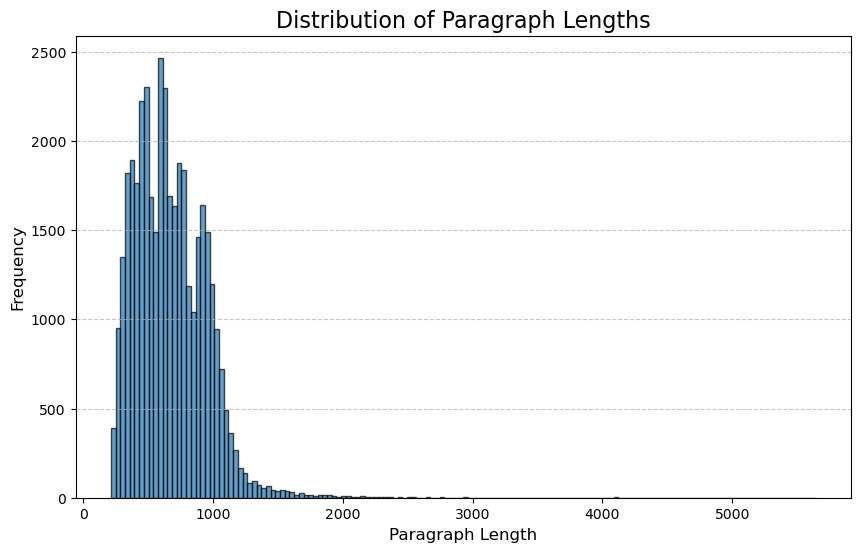

In [5]:
combined_df['paragraph_length'] = combined_df['paragraph_txt'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(combined_df['paragraph_length'], bins=150, edgecolor='black', alpha=0.7)
plt.title("Distribution of Paragraph Lengths", fontsize=16)
plt.xlabel("Paragraph Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
# paragraph의 길이가 1000 초과인 경우 제거
combined_df = combined_df[combined_df['paragraph_length'] <= 1000]

# paragraph의 길이가 300 미만인 경우 제거
combined_df = combined_df[combined_df['paragraph_length'] >= 300]

combined_df.shape

(33640, 7)

### 4. Text Data Preprocess - Detect Placeholder
- #@이름#, #@소속# 등의 태그를 추출하고, 해당 태그가 있는 경우에는 해당 데이터를 제거해주는 전처리

In [7]:
def count_patterns(text):
    ''' #로 시작하고 #로 끝나는 태그 추출 '''
    matches = re.findall(r'#.*?#', text)
    pattern_counter.update(matches)

pattern_counter = Counter()
combined_df['paragraph_txt'].apply(count_patterns)

# 많은 순으로 정렬
sorted_patterns = pattern_counter.most_common()

for pattern, count in sorted_patterns:
    print(f"{pattern}: {count}번 등장")

#@문장구분#: 358436번 등장
#@이름#: 748번 등장
#@소속#: 80번 등장
#@신원#: 74번 등장
#@주소#: 16번 등장
#@번호#: 3번 등장
#@계정#: 2번 등장
#태양계는 은하계에 속하며 같이 공전한다. #: 1번 등장
#거대한 행성과 행성들의 모임은 각각 다른 물질을 기준으로 공전한다. #: 1번 등장
#그것도 타원의 궤도로 말이다. #: 1번 등장
#왜 공전을 하며 왜 궤도는 타원인지는 알 수 있겠지만 우리가 초점을 맞추어야 할 것은 바로 이거다.#: 1번 등장
# 이것 또한 '예술'이라는 것에 말이다.#: 1번 등장
# 우주는 예술이다. #: 1번 등장
#그리고 그런 행성에 살고있는 우리는 그 경험이나 기억속의 일부인 것처럼요#: 1번 등장
#korea, #: 1번 등장
#0117), 청소년 전화1388, 각 지역의 청소년 상담복지센터, 푸른나무재단 : 1588-9128 / 학교폭력 피해학생 전담지원 '위드위(With Wee)' 센터, 청소년 꿈키움센터(법무부 비행예방센터), 대한법률구조공단 등이 있습니다. #: 1번 등장
#이후에도 고민이나 문의사항이 생기면 학교폭력상담전화 (Tel : 1588-9128)를 통해 상담원과 같이 고민해 볼 수 있습니다.#: 1번 등장
# 전화는 월~금 오전 9시부터 저녁 8시, 토요일 오전 9시부터 오후 1시까지 진행할 수 있다고 합니다. #: 1번 등장
#학교에서 친구들과 생긴 문제나 고민같이 힘든 마음은 물론 학교폭력 사안과 관련된 법률 자문도 상담원과 전화로 나눌 수 있기에 가장 현실적인 해결방법이 될 수 있다고 생각합니다. #: 1번 등장
#상담을 통해 어려움을 해쳐나갈 수 있는 용기를 얻을 수 있고, 결국에 이 용기가 본인의 어려움을 헤쳐나갈 수 있는 원동력이 되어줄 수 있다고 생각합니다.#: 1번 등장
# 그렇기에 상담이 가장 근본적이고 기초적이며 실현 가능성이 가장 큰, 가장 도움이 되는 해결방법이라고 생각합니다.#: 1번 등장
#신화#: 1번 등장
#왕#: 1번 등장
#nozi #: 

In [8]:
def preprocess_paragraph(text):
    # #로 시작하고 #로 끝나는 플레이스홀더 추출
    all_placeholders = re.findall(r'#.*?#', text)
    
    # '#@문장구분#'만 남기고 나머지 확인
    other_placeholders = [tag for tag in all_placeholders if tag != '#@문장구분#']
    
    # '#@문장구분#' 이외의 플레이스홀더가 포함된 경우 None 반환
    if other_placeholders:
        return None
    
    # '#@문장구분#'은 '\n'으로 대체
    return text.replace('#@문장구분#', '\n')

combined_df['paragraph_txt'] = combined_df['paragraph_txt'].apply(preprocess_paragraph)

# None 값 제거 (다른 플레이스홀더가 포함된 행)
combined_df = combined_df.dropna(subset=['paragraph_txt'])
combined_df.shape

(33285, 7)

### 5. Text Data Preprocess - HTML 태그 제거

In [9]:
# </div>, <br/> 등의 HTML 태그 제거
def remove_html_tags(text, row_index):
    '''
    입력 텍스트에서 HTML 태그를 제거하고 제거된 경우 로그 출력
    '''
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text()
    if cleaned_text != text:  # HTML 태그 제거된 경우
        print(f"[Row {row_index}] Removed HTML tags:")
        print(f"Before: {text}")
        print(f"After: {cleaned_text}\n")
    return cleaned_text


combined_df['paragraph_txt'] = combined_df['paragraph_txt'].progress_apply(
    lambda x: remove_html_tags(x, combined_df.index[combined_df['paragraph_txt'] == x][0])
)

 12%|█▏        | 3923/33285 [00:03<00:27, 1072.62it/s]

[Row 4508] Removed HTML tags:
Before: <div>
</div>거북이가되어 바다를모험하고 싶습니다.
 왜냐하면 거북이를 매우좋아하기 때문이다.
 
 첫째, 거북이가되어 바다속을 헤험치면서 여러산호초를 구경할것이다.
 바다속에 있는 산호초들을 거북이가되어 헤험치면서 보면 재미있을것같다.
 또한 빠르게구경할수도있으면서 여러가지 산호초를 볼수있기때문이다.
 그리고 바닷속을 헤험치면서 여러친구들을 만날것이다.
 
 둘째, 거북이친구들과같이놀것이다.
 친구들과같이 헤염도치고, 다른친구들도 만날것이다.
 그리고 친구들과 같이 누가더빠른지 경기를 할것이고 엄청나게 재미있을 것이다.
 
 셋째, 바다빡으로 나가서 따뜻한 햇빛에 몸을데우면서 장을갈것이다.
 따뜻한 햇빛은 너무나 따뜻해나의몸을 느겨주고 나는 따뜻한 햇빛을 함게하면서 잠을잘것이다.
 마음이 너무나 따뜻하고편안하다.
 그리고 잠에서 깨다시 바다속으로 돌아간다.
 
넷재, 마지막으로 바다속에서 여러지역으로 여행갈것이다.
 힘들고어렵겠지만 너무나 기대가 된다.
 그리고 여러지역에 있는 거북이친구들은 어떤모습일지 궁금하다.
 또한 너무나 재미있는 여행이 될것이다.
After: 
거북이가되어 바다를모험하고 싶습니다.
 왜냐하면 거북이를 매우좋아하기 때문이다.
 
 첫째, 거북이가되어 바다속을 헤험치면서 여러산호초를 구경할것이다.
 바다속에 있는 산호초들을 거북이가되어 헤험치면서 보면 재미있을것같다.
 또한 빠르게구경할수도있으면서 여러가지 산호초를 볼수있기때문이다.
 그리고 바닷속을 헤험치면서 여러친구들을 만날것이다.
 
 둘째, 거북이친구들과같이놀것이다.
 친구들과같이 헤염도치고, 다른친구들도 만날것이다.
 그리고 친구들과 같이 누가더빠른지 경기를 할것이고 엄청나게 재미있을 것이다.
 
 셋째, 바다빡으로 나가서 따뜻한 햇빛에 몸을데우면서 장을갈것이다.
 따뜻한 햇빛은 너무나 따뜻해나의몸을 느겨주고 나는 따뜻한 햇빛을 함게하면서 잠을잘것이다.
 마음이 너무나 따뜻하고편안하다.
 그리고 잠에서 깨

 23%|██▎       | 7738/33285 [00:07<00:24, 1041.50it/s]

[Row 9776] Removed HTML tags:
Before: 나는 예전에 본 영화 <sing>에 대한 감상문을 적어보려고 한다. 영화 <sing>에서, 망해가는 극장인 문 극장을 살리기 위해 코알라인 버스터 문이 대국민 오디션을 개최한다. 하지만 한순간의 실수로 상금이 1000달러(약 100만원)에서 10만달러(약 1억)으로 바뀌게 되고 이로 인해서 아주아주 많은 동물들이 오디션을 보러 온다. 그 중에는 25남매를 키우고 있는 돼지엄마 로지타, 남자친구와 록스타를 꿈꾸는 고슴도치 애쉬, 범죄자 아버지를 둔 고릴라 조니, 무대 공포증을 갖고 있는 코끼리 미나, 오직 상금이 목적인 생쥐 마이크가 모두 꿈을 위해 무대에 오른다. 내가 이 영화를 좋아하는 이유는 바로 모든 캐릭터 하나하나가 각자의 스토리를 갖고 매력이 넘치기 때문이다. 노래와 춤을 좋아하지만 육아로 인해 지친 로지타와 남자친구와의 불협으로 인한 갈등이 심한 애쉬, 범죄자 아버지에게 자신의 가수로서의 꿈을 이야기하지 못하는 조니와 음색이 정말 매력적이지만 남들 앞에서 노래를 해 본적이 없는 미나, 명문대 음대를 나왔지만 성격이 좋지 못한 마이크가 하나하나 톡톡 튀면서도 서로 잘 섞여들어 영화를 빛냈다. 특히 조니가 노래를 부를 때에 교도소에 있는 아빠가 TV를 보고 뛰쳐나와서 조니에게 사과하러 가는 장면은 정말 눈물이 날 뻔 했다. 물론 어려운 부분도 모두 있었지만 자신의 꿈을 위해 모두 포기하지 않았고 결국 무대를 빛내고 문 극장을 지킬 수 있었다. 나는 지금까지 여러 영화를 봤지만 이렇게 영화 캐릭터들이 톡톡 튀는 영화를 본 적이 없는 것 같다. 이번에 <sing2>가 나온다는데 꼭 한번 보고 싶다.
					
					
				</sing2></sing></sing>
After: 나는 예전에 본 영화 에 대한 감상문을 적어보려고 한다. 영화 에서, 망해가는 극장인 문 극장을 살리기 위해 코알라인 버스터 문이 대국민 오디션을 개최한다. 하지만 한순간의 실수로 상금이 1000달러(약 100만원

 24%|██▍       | 7947/33285 [00:07<00:24, 1033.30it/s]

[Row 10118] Removed HTML tags:
Before: 나는 '미움 받을 용기' 라는 책을 읽고 책 안에 너무 좋은 글과 유식한 지식이 많아서 책을 읽으면서 내 삶을 뒤돌아 보는 계기가 된 거 같다.
 이 책에서 기억나는 글을 써 볼 것이다.
 너무 많지만...
<br/>인간은 변할 수 있다,
 세계는 단순하다,
 누구나 행복해질 수 있다.
 "자네가 불행한 것은 과거의 환경 탓이 아니네.
 그렇다고 능력이 부족해서도 아니고.
 자네에게는 그저 '용기'가 부족한 것 뿐이야."
 모든 고민은 인간관계에서 비롯된다.
 타인의 기대 같은 것은 만족시킬 필요가 없다.
" 나는 이 책을 읽고 많은 행동과 생각이 달라졌다.
 '미움 받을 용기'라는 책은 보물이다.
 보면 볼수록 좋은 말들이 나온다."
 누구도 내 과제에 개입시키지 말고, 나도 타인의 과제에 개입하지 않는다.
 "You have to have the courage to be hated to be happy.

After: 나는 '미움 받을 용기' 라는 책을 읽고 책 안에 너무 좋은 글과 유식한 지식이 많아서 책을 읽으면서 내 삶을 뒤돌아 보는 계기가 된 거 같다.
 이 책에서 기억나는 글을 써 볼 것이다.
 너무 많지만...
인간은 변할 수 있다,
 세계는 단순하다,
 누구나 행복해질 수 있다.
 "자네가 불행한 것은 과거의 환경 탓이 아니네.
 그렇다고 능력이 부족해서도 아니고.
 자네에게는 그저 '용기'가 부족한 것 뿐이야."
 모든 고민은 인간관계에서 비롯된다.
 타인의 기대 같은 것은 만족시킬 필요가 없다.
" 나는 이 책을 읽고 많은 행동과 생각이 달라졌다.
 '미움 받을 용기'라는 책은 보물이다.
 보면 볼수록 좋은 말들이 나온다."
 누구도 내 과제에 개입시키지 말고, 나도 타인의 과제에 개입하지 않는다.
 "You have to have the courage to be hated to be happy.


[Row 10122] Removed HTML tags:
Before: 이

 53%|█████▎    | 17757/33285 [00:17<00:14, 1044.30it/s]

[Row 21498] Removed HTML tags:
Before: <div>
</div>세상에는 아주 다양한 취미활동이 있죠!
 예를 들면 그림, 컬러링, 게임, 운동 등 여러가지의 취미활동이 있어요.

 그중 저의 취미활동은 요리인데요!
 저는 그중 빵, 과일 등 조금 달달하고 쉽게 먹을 수 있는 디져트 같은 것들을 만드는걸 좋아해요!

 처음엔 저도 요리를 좋아하지는 않았어요.
 근데 엄마와 함께 샌드위치를 만든 날 이후 음식을 만드는 것이 좋아지기 시작했어요!
 그 뒤로 요리를 하는게 좋고 행복해지기 시작했어요!
 텔레비전에 나오는 요리프로그램 속 요리를 잘하는 사람들을 보고 저는 '우와 나도 해보고 싶다' 라고 생각했었어요.
 저는 그때부터 요리하는게 취미가 되었어요!
After: 
세상에는 아주 다양한 취미활동이 있죠!
 예를 들면 그림, 컬러링, 게임, 운동 등 여러가지의 취미활동이 있어요.

 그중 저의 취미활동은 요리인데요!
 저는 그중 빵, 과일 등 조금 달달하고 쉽게 먹을 수 있는 디져트 같은 것들을 만드는걸 좋아해요!

 처음엔 저도 요리를 좋아하지는 않았어요.
 근데 엄마와 함께 샌드위치를 만든 날 이후 음식을 만드는 것이 좋아지기 시작했어요!
 그 뒤로 요리를 하는게 좋고 행복해지기 시작했어요!
 텔레비전에 나오는 요리프로그램 속 요리를 잘하는 사람들을 보고 저는 '우와 나도 해보고 싶다' 라고 생각했었어요.
 저는 그때부터 요리하는게 취미가 되었어요!



 79%|███████▉  | 26257/33285 [00:25<00:06, 1057.96it/s]C:\Users\gyg_9\AppData\Local\Temp\ipykernel_18152\528753730.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 33285/33285 [00:32<00:00, 1032.92it/s]


### Preprocess 완료

In [10]:
# preprocess 이후 통합 데이터프레임 저장
combined_df.to_csv(CFG.DF_AFTER_PREPROCESS_CSV_PATH, index=False, encoding='utf-8-sig')
combined_df.shape

(33285, 7)

# Train & Valid & TEST Split

In [11]:
### === 글 종류('essay_type') === ###
# 1. 글짓기
# 2. 대안제시
# 3. 설명글
# 4. 주장
# 5. 찬성반대
# ================================= #


### === 학년('student_grade') === ###
# 고등_1학년, 고등_2학년, 고등_3학년
# 중등_1학년, 중등_2학년, 중등_3학년 
# 초등_4학년, 초등_5학년, 초등_6학년
# ================================= #


### === 구축하고자 하는 데이터셋 분포 === ### 
# Train Dataset: 4500 (초,중,고 별로 300개씩)
# 1. 글짓기 900 
# 2. 대안제시 900
# 3. 설명글 900
# 4. 주장 900
# 5. 찬성반대 900

# Validation Dataset: 450 (초,중,고 별로 300개씩)
# 1. 글짓기 90
# 2. 대안제시 90
# 3. 설명글 90
# 4. 주장 90
# 5. 찬성반대 90

# Test Dataset: 450 (초,중,고 별로 300개씩)
# 1. 글짓기 90 
# 2. 대안제시 90
# 3. 설명글 90
# 4. 주장 90
# 5. 찬성반대 90
# ================================= #

### Dataset Shuffle 

In [12]:
# 데이터셋 index를 섞는다.
combined_df = combined_df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

### Split train, valid, test

In [13]:
def split_dataset_with_topics(df, train_size_per_level, valid_size_per_level, test_size_per_level):
    # 'education_level': 초등, 중등, 고등을 나눈 것
    df['education_level'] = df['student_grade'].apply(
        lambda x: '초등' if '초등' in x else ('중등' if '중등' in x else '고등')
    )

    train = []
    valid = []
    test = []

    # Group by 'essay_type' and 'education_level'
    grouped = df.groupby(['essay_type', 'education_level'])

    for (essay_type, education_level), group in grouped:
        total_required = train_size_per_level + valid_size_per_level + test_size_per_level

        if len(group) >= total_required:
            # Sample required data
            sampled_group = group.sample(n=total_required, random_state=42)
        else:
            print(f"Not enough data for {essay_type} - {education_level}: {len(group)} samples available. Using all available data.")
            sampled_group = group

        # Split into train, valid, and test
        train.append(sampled_group.iloc[:min(train_size_per_level, len(sampled_group))])
        valid_start = min(train_size_per_level, len(sampled_group))
        valid.append(sampled_group.iloc[valid_start:valid_start + min(valid_size_per_level, len(sampled_group) - valid_start)])
        test_start = valid_start + min(valid_size_per_level, len(sampled_group) - valid_start)
        test.append(sampled_group.iloc[test_start:test_start + min(test_size_per_level, len(sampled_group) - test_start)])

    # Concatenate the datasets
    train_df = pd.concat(train, ignore_index=True)
    valid_df = pd.concat(valid, ignore_index=True)
    test_df = pd.concat(test, ignore_index=True)

    return train_df, valid_df, test_df


train_df, valid_df, test_df = split_dataset_with_topics(combined_df, CFG.TRAIN_SIZE_PER_LEVEL, CFG.VALID_SIZE_PER_LEVEL, CFG.TEST_SIZE_PER_LEVEL)

print("Train shape:", train_df.shape)
print("Validation shape:", valid_df.shape)
print("Test shape:", test_df.shape)

train_df.to_csv(CFG.DF_HUMAN_TRAIN_CSV_PATH, index=False, encoding='utf-8-sig')
valid_df.to_csv(CFG.DF_HUMAN_VALID_CSV_PATH, index=False, encoding='utf-8-sig')
test_df.to_csv(CFG.DF_HUMAN_TEST_CSV_PATH, index=False, encoding='utf-8-sig')

Train shape: (4500, 8)
Validation shape: (450, 8)
Test shape: (450, 8)


# Statistics

In [14]:
datasets = {'Train': train_df, 'Validation': valid_df, 'Test': test_df}

for dataset_name, df in datasets.items():
    print(f"\n{dataset_name} Dataset:")
    
    # 'essay_type' 카운트
    essay_type_counts = df['essay_type'].value_counts()
    print(f"'essay_type' Counts:")
    print(essay_type_counts)
    
    # 'education_level' 카운트
    education_level_counts = df['education_level'].value_counts()
    print(f"\n'education_level' Counts:")
    print(education_level_counts)


Train Dataset:
'essay_type' Counts:
essay_type
글짓기     900
대안제시    900
설명글     900
주장      900
찬성반대    900
Name: count, dtype: int64

'education_level' Counts:
education_level
고등    1500
중등    1500
초등    1500
Name: count, dtype: int64

Validation Dataset:
'essay_type' Counts:
essay_type
글짓기     90
대안제시    90
설명글     90
주장      90
찬성반대    90
Name: count, dtype: int64

'education_level' Counts:
education_level
고등    150
중등    150
초등    150
Name: count, dtype: int64

Test Dataset:
'essay_type' Counts:
essay_type
글짓기     90
대안제시    90
설명글     90
주장      90
찬성반대    90
Name: count, dtype: int64

'education_level' Counts:
education_level
고등    150
중등    150
초등    150
Name: count, dtype: int64
